In [1]:
import os
import numpy as np

import torch

from pathlib import Path

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import colors

import sys

from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src/models/'))) 
from encoder1 import recon_model

# Add parent directory to path for imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../NN/ptychosaxsNN/')))
import utils.ptychosaxsNN_utils as ptNN_U

import importlib
importlib.reload(ptNN_U)

<module 'utils.ptychosaxsNN_utils' from '/home/beams0/PTYCHOSAXS/NN/ptychosaxsNN/utils/ptychosaxsNN_utils.py'>

In [2]:
#Load lowest validation loss model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_new=recon_model()
model_new.load_state_dict(torch.load("/net/micdata/data2/12IDC/ptychosaxs/models/best_model_ZCB_9_dr17.pth"))
model_new.to(device)

#put into eval mode
model_new.eval()

recon_model(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): R

In [3]:
# load ZCB_9_3D diffraction data
base_path="/net/micdata/data2/12IDC/2025_Feb/ptycho/"
scan_numbers=[5065]#np.arange(5004,5189,1)#[5045,5065,5102,5150]
all_dps=[]
for scan_number in scan_numbers:
    print(f"Loading scan {scan_number}")
    dps=ptNN_U.load_h5_scan_to_npy(base_path, scan_number, plot=False,point_data=True)
    all_dps.append(dps)
all_dps=np.asarray(all_dps)

Loading scan 5065


100%|██████████| 1043/1043 [00:10<00:00, 98.78it/s] 


In [4]:
#summed diffraction pattern

print(all_dps.shape)
dp=np.sum(all_dps[0],axis=0)

(1, 1043, 1043, 981)


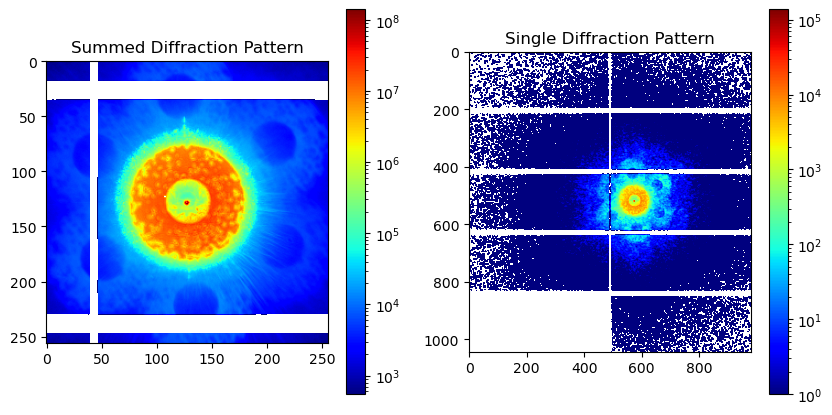

In [5]:
#scan informtion
ncols=36
nrows=29
center=(517,575)

#crop diffraction patterns
dpsize=256
dp=dp[center[0]-dpsize//2:center[0]+dpsize//2,
    center[1]-dpsize//2:center[1]+dpsize//2]
# dp=dps[666][center[0]-dpsize//2:center[0]+dpsize//2,
#     center[1]-dpsize//2:center[1]+dpsize//2]
#plot diffraction patterns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im1=axs[0].imshow(dp, cmap='jet',norm=colors.LogNorm())
axs[0].set_title('Summed Diffraction Pattern')
im2=axs[1].imshow(dps[666], cmap='jet',norm=colors.LogNorm())
axs[1].set_title('Single Diffraction Pattern')
plt.colorbar(im1)
plt.colorbar(im2)
plt.show()


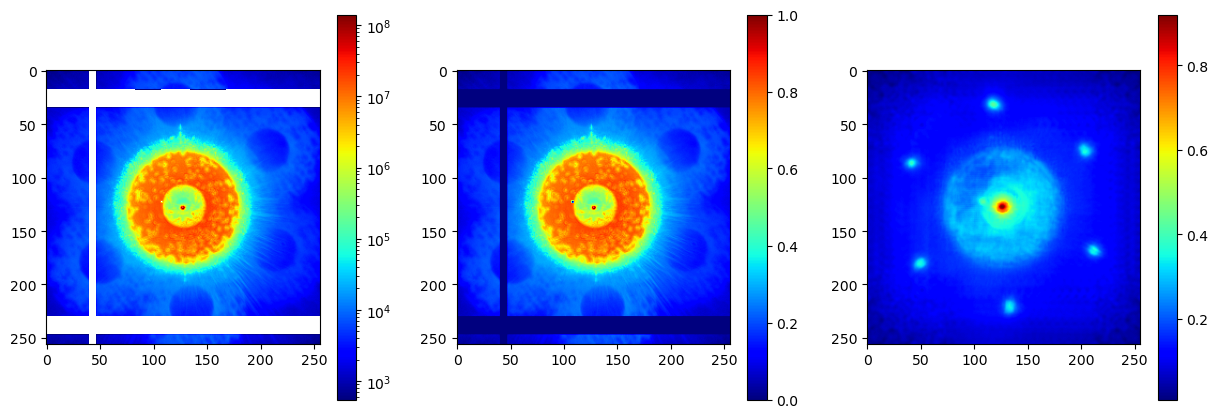

In [6]:
#preprocess diffraction pattern
mask = np.load('/home/beams/PTYCHOSAXS/deconvolutionNN/data/mask/mask_ZCB_9_3D.npy')
resultT, sfT, bkgT = ptNN_U.preprocess_ZCB_9(dp,mask)
#resultT, sfT, bkgT = ptNN_U.preprocess_ZCB_9(dp, create_circular_waxs_mask_min_value(mask,54))

#plot diffraction pattern and deconvolved pattern
fig,ax=plt.subplots(1,3,figsize=(15,5))
im1=ax[0].imshow(dp,norm=colors.LogNorm(),cmap='jet')
im2=ax[1].imshow(resultT[0][0],cmap='jet')
im3=ax[2].imshow(model_new(resultT.to(device=device, dtype=torch.float)).detach().to("cpu").numpy()[0][0],cmap='jet')
plt.colorbar(im1)
plt.colorbar(im2)
plt.colorbar(im3)
plt.show()

In [37]:
def plot_full_scan(dps, mask, model, scanx=36, scany=29, dpsize=256, center=(517,575)):
    """
    Plot diffraction patterns from a 2D scan more efficiently.
    """
    # Create figure and axes once
    fig, axs = plt.subplots(scany, scanx, figsize=(scanx, scany))
    fig.subplots_adjust(hspace=0, wspace=0)
    
    # Handle different dimensions of axs
    if scany == 1 and scanx == 1:
        axs = np.array([[axs]])
    elif scany == 1:
        axs = np.array([axs])
    elif scanx == 1:
        axs = np.array([[ax] for ax in axs])
    
    # Pre-calculate indices for cropping
    y_start = center[0] - dpsize//2
    y_end = center[0] + dpsize//2
    x_start = center[1] - dpsize//2
    x_end = center[1] + dpsize//2
    
    count = 0
    inputs = []
    outputs = []
    sfs = []
    bkgs = []
    
    # Turn off all axes at once
    for ax_row in axs:
        for ax in ax_row:
            ax.axis('off')
    
    # Process in batches for better performance
    try:
        # Use tqdm for progress tracking
        pbar = tqdm(total=scanx*scany)
        
        for i in range(scany):
            for j in range(scanx):
                if count >= len(dps):
                    break
                    
                # Crop the diffraction pattern
                dp_count = dps[count][y_start:y_end, x_start:x_end]
                
                # Plot the result
                im = axs[i][j].imshow(dp_count, cmap='jet',norm=colors.LogNorm())
                
                count += 1
                pbar.update(1)
                
        pbar.close()
                
    except KeyboardInterrupt:
        print("\nProcessing interrupted by user (Ctrl+C)")
        # Continue with plotting what we have so far
    
    # Only add colorbar if we processed at least one image
    if count > 0:
        cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
    
    plt.tight_layout()
    plt.show()
    
    return 0
        

100%|█████████▉| 1043/1044 [00:02<00:00, 433.43it/s]
/tmp/ipykernel_944797/4016792677.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


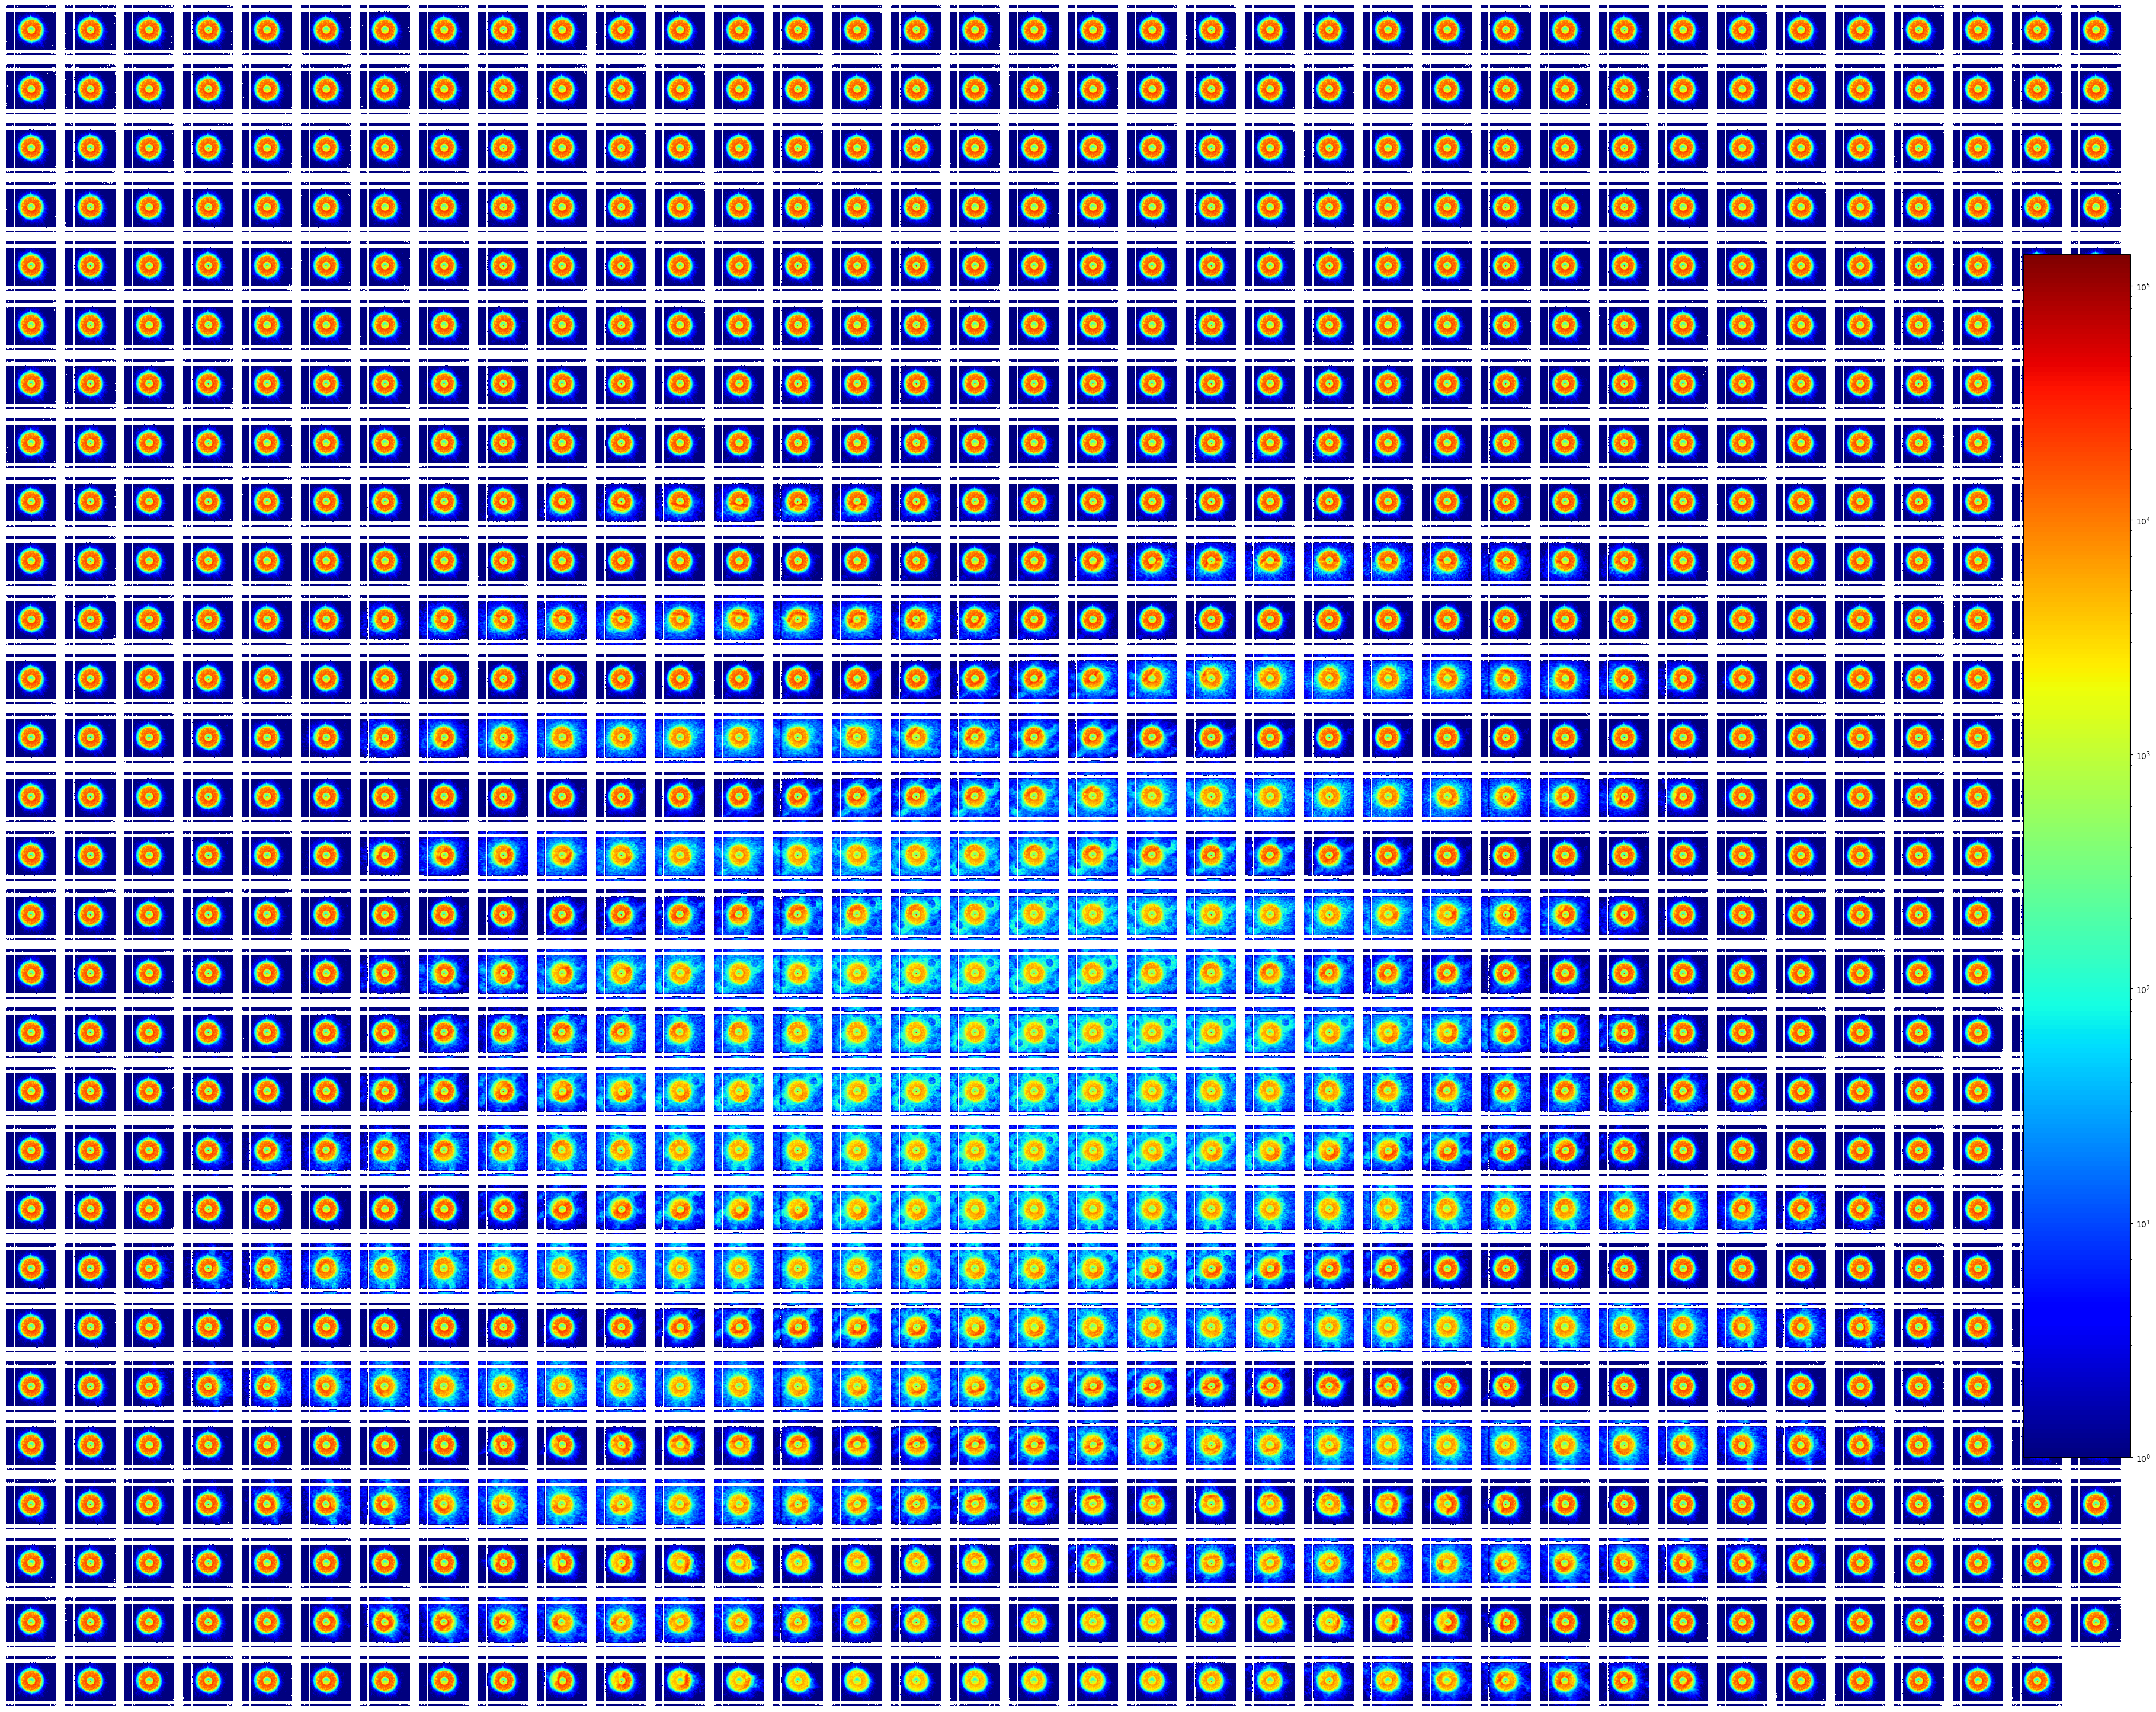

0

In [38]:
plot_full_scan(dps,mask,model_new,scanx=36,scany=29)

In [ ]:
import os
import glob

def check_scan_completeness(base_path, scan_name, scan_id, start_i=1, end_i=29, start_j=1, end_j=36):
    """
    Check if all files in a scan sequence exist and identify unexpected files.
    """
    expected_files = []
    missing_files = []
    expected_filenames = set()
    
    # Generate all expected filenames
    for i in range(start_i, end_i + 1):
        for j in range(start_j, end_j + 1):
            filename = f"{scan_name}_{scan_id}_{i:05d}_{j:05d}.h5"
            full_path = os.path.join(base_path, filename)
            expected_files.append(full_path)
            expected_filenames.add(filename)
    
    # Check which files exist
    for file_path in expected_files:
        if not os.path.exists(file_path):
            missing_files.append(file_path)
    
    total_expected = len(expected_files)
    found = total_expected - len(missing_files)
    
    # Get a list of all actual files for comparison
    actual_files = glob.glob(os.path.join(base_path, f"{scan_name}_{scan_id}_*.h5"))
    
    # Find unexpected files (files that exist but don't match the expected pattern)
    unexpected_files = []
    for file_path in actual_files:
        filename = os.path.basename(file_path)
        if filename not in expected_filenames:
            unexpected_files.append(file_path)
    
    return {
        'complete': len(missing_files) == 0,
        'total_expected': total_expected,
        'found': found,
        'missing': missing_files,
        'completion_percentage': (found / total_expected) * 100 if total_expected > 0 else 0,
        'actual_file_count': len(actual_files),
        'unexpected_files': unexpected_files
    }
# Example usage
base_path = '/net/micdata/data2/12IDC/2025_Feb/ptycho/5045'
scan_name = 'ZCB_9_3D'
scan_id = '5045'

result = check_scan_completeness(base_path, scan_name, scan_id)

if result['complete']:
    print(f"Scan is complete! All {result['total_expected']} files found.")
else:
    print(f"Scan is incomplete. Found {result['found']} of {result['total_expected']} files ({result['completion_percentage']:.1f}%).")
    print(f"Total files in directory: {result['actual_file_count']}")
    
    # Print first few missing files if any
    if len(result['missing']) > 0:
        print("\nMissing files:")
        for file in result['missing'][:]:
            print(f"  - {os.path.basename(file)}")
        
    # Print unexpected files
    if len(result['unexpected_files']) > 0:
        print("\nUnexpected files (don't match the pattern):")
        for file in result['unexpected_files']:
            print(f"  - {os.path.basename(file)}")

Scan is incomplete. Found 1033 of 1044 files (98.9%).
Total files in directory: 1044

Missing files:
  - ZCB_9_3D_5045_00018_00026.h5
  - ZCB_9_3D_5045_00018_00027.h5
  - ZCB_9_3D_5045_00018_00028.h5
  - ZCB_9_3D_5045_00018_00029.h5
  - ZCB_9_3D_5045_00018_00030.h5
  - ZCB_9_3D_5045_00018_00031.h5
  - ZCB_9_3D_5045_00018_00032.h5
  - ZCB_9_3D_5045_00018_00033.h5
  - ZCB_9_3D_5045_00018_00034.h5
  - ZCB_9_3D_5045_00018_00035.h5
  - ZCB_9_3D_5045_00018_00036.h5

Unexpected files (don't match the pattern):
  - ZCB_9_3D_5045_00019_00037.h5
  - ZCB_9_3D_5045_00019_00038.h5
  - ZCB_9_3D_5045_00019_00039.h5
  - ZCB_9_3D_5045_00019_00040.h5
  - ZCB_9_3D_5045_00019_00041.h5
  - ZCB_9_3D_5045_00019_00042.h5
  - ZCB_9_3D_5045_00019_00043.h5
  - ZCB_9_3D_5045_00019_00044.h5
  - ZCB_9_3D_5045_00019_00045.h5
  - ZCB_9_3D_5045_00019_00046.h5
  - ZCB_9_3D_5045_00019_00047.h5


In [50]:
def plot_and_save_scan(dps, mask, model, base_path, scan_name, scan_id, scanx=36, scany=29, dpsize=256, center=(517,575)):
    """
    Plot diffraction patterns from a 2D scan, handling missing points and skipping outliers.
    """
    print(f"Total diffraction patterns: {len(dps)}")
    
    # First check scan completeness
    scan_check = check_scan_completeness(base_path, scan_name, scan_id, start_i=1, end_i=scany, start_j=1, end_j=scanx)
    print(f"Found {scan_check['found']} of {scan_check['total_expected']} expected files")
    print(f"Missing files: {len(scan_check['missing'])}")
    print(f"Unexpected files: {len(scan_check['unexpected_files'])}")
    
    # Get all files in the directory in ascending order
    all_files = sorted(glob.glob(os.path.join(base_path, f"{scan_name}_{scan_id}_*.h5")))
    print(f"Total files found in directory: {len(all_files)}")
    
    # Extract indices from filenames
    file_indices = []
    for file_path in all_files:
        filename = os.path.basename(file_path)
        parts = filename.split('_')
        if len(parts) >= 4:
            try:
                i = int(parts[-2])
                j = int(parts[-1].split('.')[0])
                file_indices.append((i, j))
            except ValueError:
                print(f"Could not parse indices from filename: {filename}")
                file_indices.append(None)
    
    # Identify outliers (files with indices outside the expected range)
    outlier_indices = []
    for idx, indices in enumerate(file_indices):
        if indices is None or indices[0] < 1 or indices[0] > scany or indices[1] < 1 or indices[1] > scanx:
            outlier_indices.append(idx)
    
    print(f"Identified {len(outlier_indices)} outliers")
    
    # Create figure and axes
    fig, axs = plt.subplots(scany, scanx, figsize=(scanx, scany))
    fig.subplots_adjust(hspace=0, wspace=0)
    
    # Handle different dimensions of axs
    if scany == 1 and scanx == 1:
        axs = np.array([[axs]])
    elif scany == 1:
        axs = np.array([axs])
    elif scanx == 1:
        axs = np.array([[ax] for ax in axs])
    
    # Pre-calculate indices for cropping
    y_start = center[0] - dpsize//2
    y_end = center[0] + dpsize//2
    x_start = center[1] - dpsize//2
    x_end = center[1] + dpsize//2
    
    # Turn off all axes at once
    for ax_row in axs:
        for ax in ax_row:
            ax.axis('off')
    
    # Create a blank image for missing points
    blank_image = np.zeros((dpsize, dpsize))
    
    # Fill all positions with blank images first (for missing points)
    for i in range(scany):
        for j in range(scanx):
            axs[i][j].imshow(blank_image, cmap='viridis')
    
    # Process diffraction patterns
    try:
        # Use tqdm for progress tracking
        pbar = tqdm(total=len(dps))
        
        # Keep track of processed diffraction patterns
        processed_count = 0
        
        # Process each diffraction pattern
        for dp_idx, dp in enumerate(dps):
            try:
                # Skip outliers
                if dp_idx in outlier_indices:
                    print(f"Skipping outlier at index {dp_idx}")
                    pbar.update(1)
                    continue
                
                # Get the position in the grid
                if dp_idx < len(file_indices) and file_indices[dp_idx] is not None:
                    i, j = file_indices[dp_idx]
                    # Convert to 0-based indices
                    i -= 1
                    j -= 1
                    
                    if 0 <= i < scany and 0 <= j < scanx:
                        # Crop the diffraction pattern
                        dp_cropped = dp[y_start:y_end, x_start:x_end]
                        
                        # Simple visualization without processing
                        im = axs[i][j].imshow(dp_cropped, cmap='viridis', norm=colors.LogNorm())
                        processed_count += 1
                    else:
                        print(f"Warning: Indices out of range: i={i+1}, j={j+1}")
                else:
                    print(f"Warning: No valid indices for dp_idx {dp_idx}")
                
                pbar.update(1)
                
            except Exception as e:
                print(f"Error processing dp {dp_idx}: {str(e)}")
                pbar.update(1)
                continue
            
        pbar.close()
        print(f"Successfully processed {processed_count} diffraction patterns")
        
    except KeyboardInterrupt:
        print("\nProcessing interrupted by user (Ctrl+C)")
    
    # Add colorbar if we have at least one image
    if 'im' in locals():
        cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
    
    plt.tight_layout()
    plt.show()
    
    return 0

Total diffraction patterns: 1043
Found 0 of 1044 expected files
Missing files: 1044
Unexpected files: 0
Total files found in directory: 0
Identified 0 outliers


100%|██████████| 1043/1043 [00:00<00:00, 398820.23it/s]


Successfully processed 0 diffraction patterns


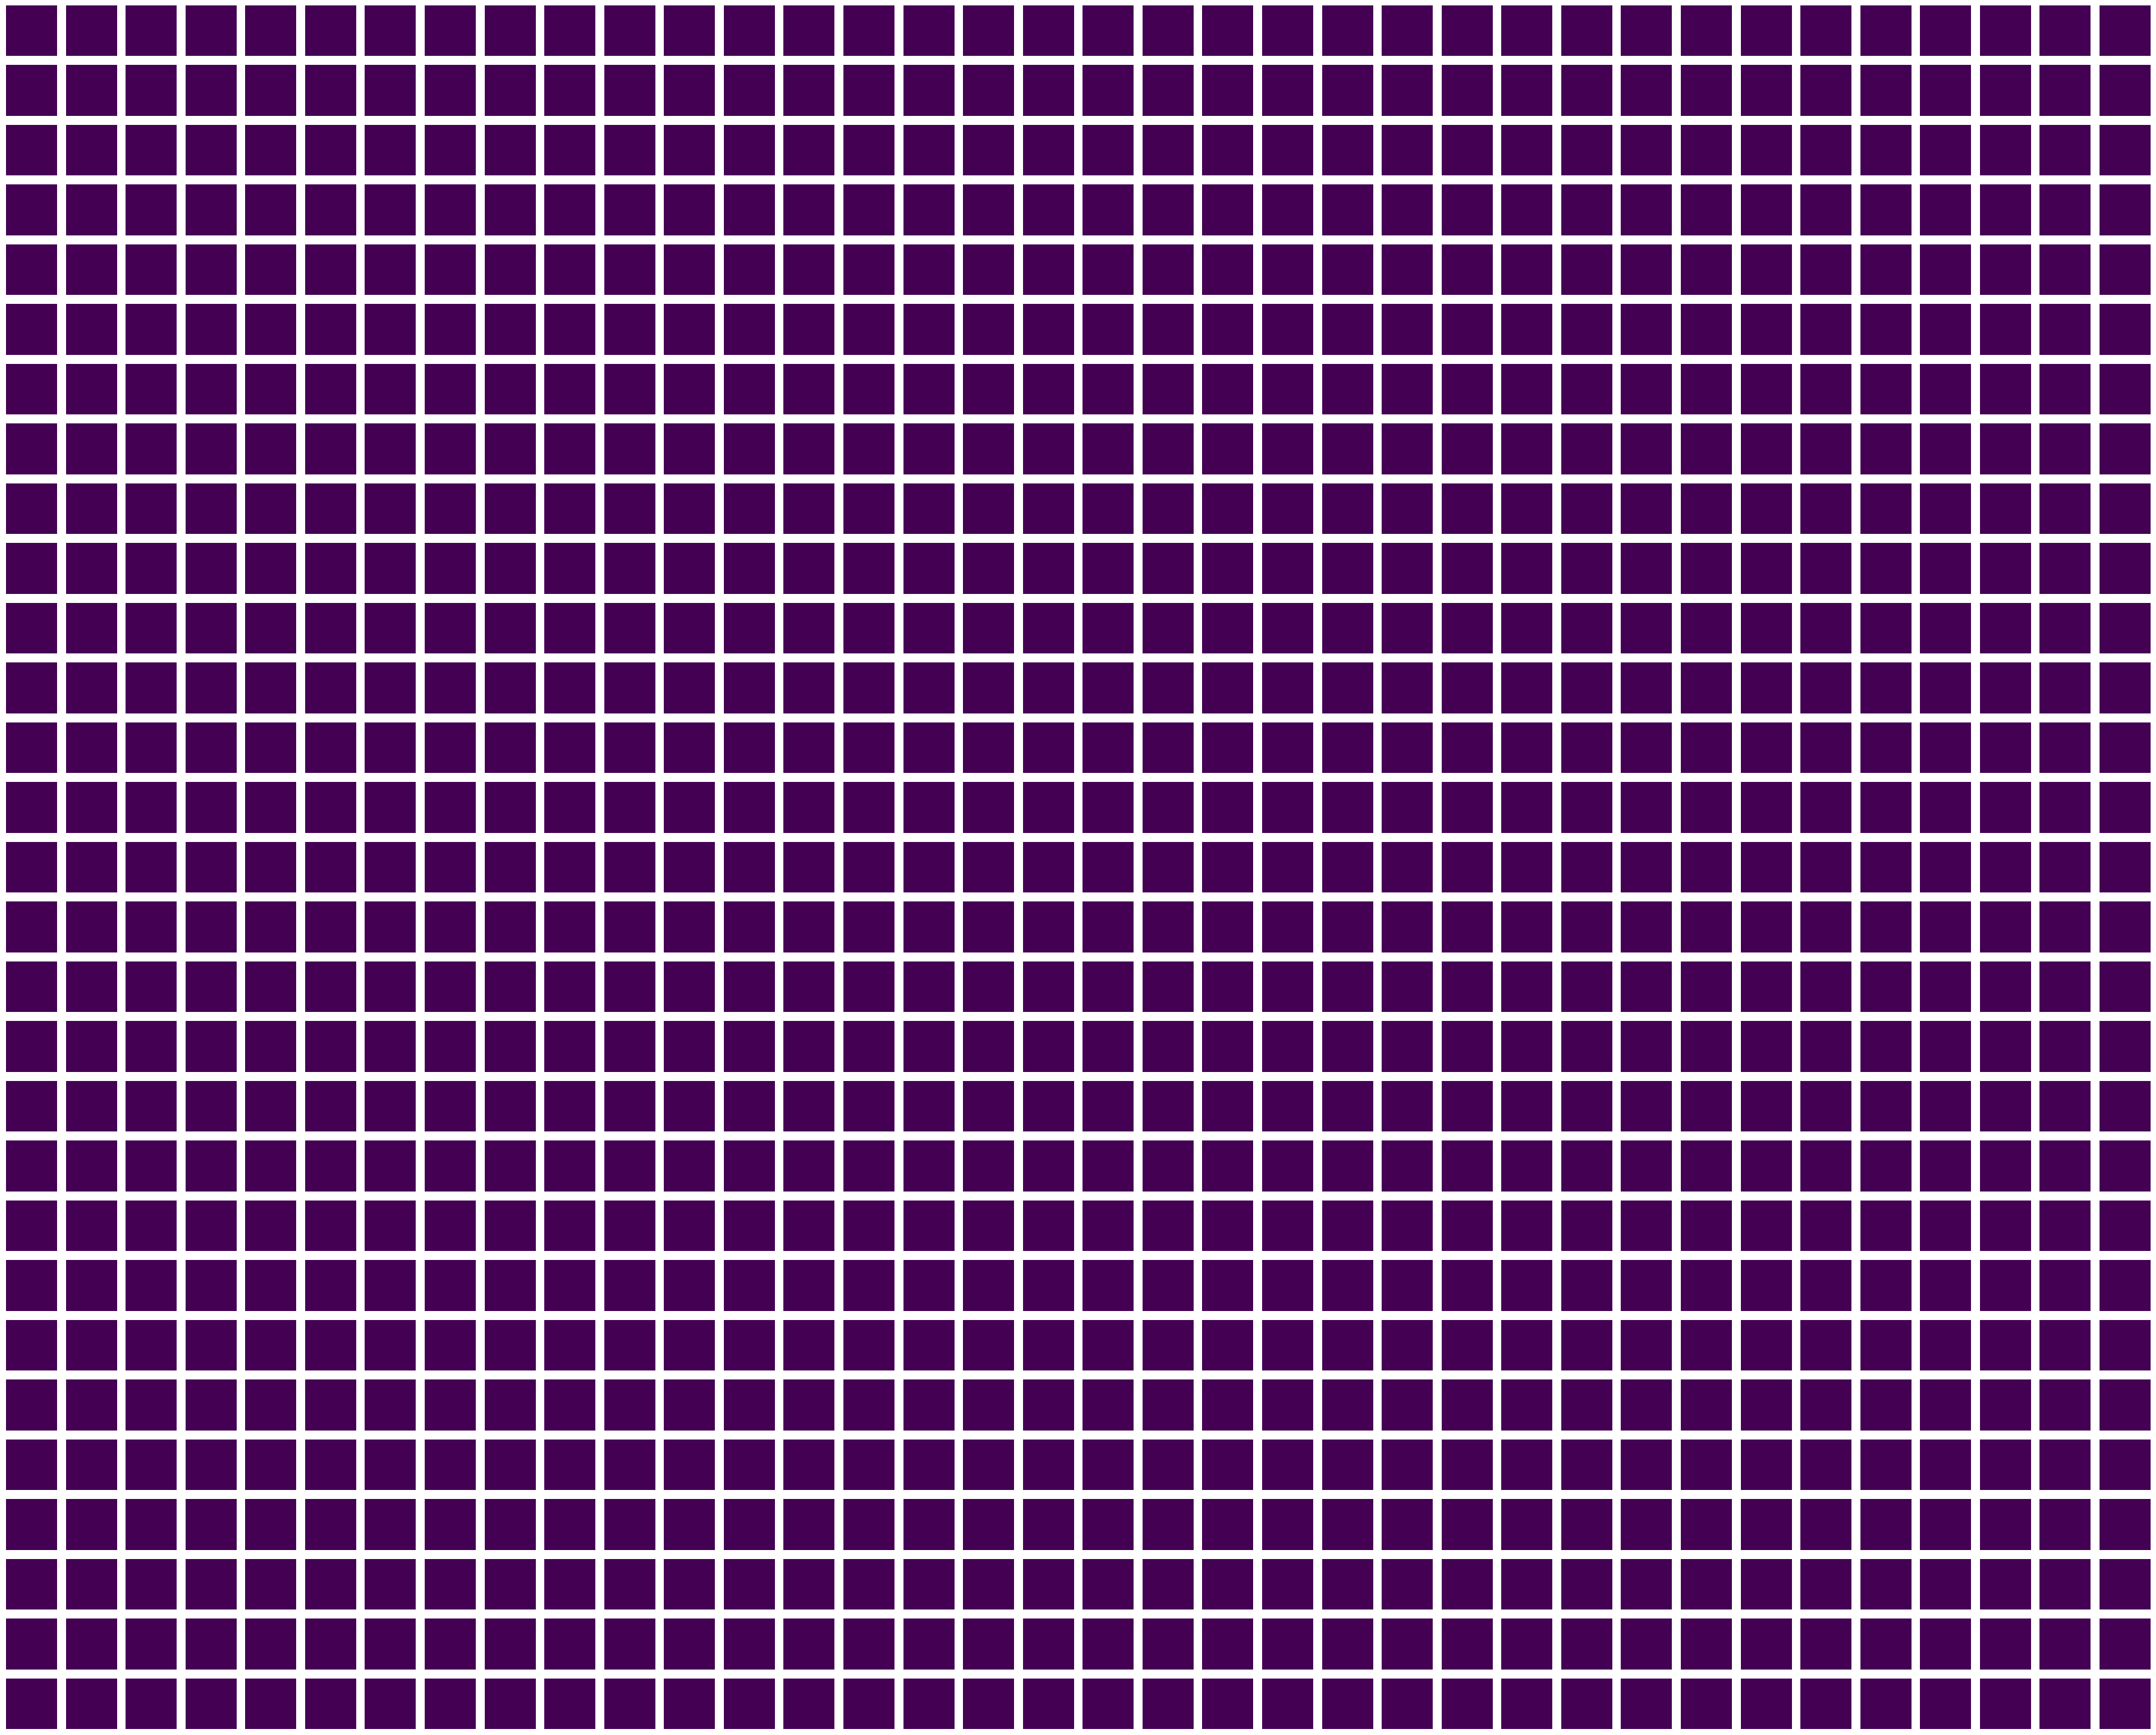

0

In [51]:
plot_and_save_scan(dps,mask,base_path,scan_name,scan_id,model_new)